# Star and Director Effects on Box Office Successes

#### Group 64: Granny Smith Geckos
- Amal Alhaidari (A98069538)
- Brandon Tong (A13957535)
- Weijin Xu (A13913775)
- Quyen-Vi Nguyen (A13553619)

### INTRO AND BACKGROUND

#### Overview
Discussed known information on movie success based on certain variables and isolated social media presence to be left out in many predictions. Located dataset of movies with social media measurement and cleaned extraneous information outside the scope of interest. Performed comparison of distributions and normality tests followed by regression models. Afterwards, concluded that social media presence is a poor indicator for a movie’s gross income

#### Research Question
Which is a better predictor of a movie’s gross income, the actors’ or the director’s FB likes?
*Note: We generalize popularity to FB likes due to the nature of social media being used to promote certain individuals

#### Background and Prior Work 
Since Barry Litman’s initial study of financial film success in 1983, multiple newer studies have tried to make more multiple regression models to find new or confirm old determinants of box office success. In their models, they compared revenue, as a dependent variable, to possible determinants of profitability as the independent variables. The overall evidence between multiple studies’ variables that have consistently shown to be significantly and positively correlated to revenue have been production cost, the assistance of a major distributor, academy award nominations, and sequels with the strongest relationship being production budget. Other possible factors such as critic reviews, time of release, advertising and specific genres are less certain since the correlational findings across different studies show contradictory results. Additionally, there have been other studies that have analyzed stock markets and simulations to look at the specific relationship between star power and box office performance, however these studies’ findings contradict each other, leading us to conclude that there are no conclusive findings yet. 

Our interest in this topic stems from the possibility of there being another possible measurement of star power and the effects it may have on the financial success of movies: social media. Social media has played a growing part in how society keeps up to date on what’s happening in pop culture. This project will use Facebook likes as a measurement of the attention a star or director garners from the public and correlate these values to see if these parts of the creative sphere affect the box office.

References: 
* [Determinants of Motion Picture Box Office and Profitability: An Interrelationship Approach](https://www.marketingcenter.de/sites/mcm/files/downloads/research/lmm/literature/hennig-thurau_et_al._2007_rms_determinants_of_motion_picture_box_office_and_profitability_an_interrelationship_approach.pdf?fbclid=IwAR1ggtw2b3jv_UDPUuA69VFWVKoGRI4bx1QQtQtSNFbXuqr8ykiz3hStico)
* [The Determinants Of Domestic Box Office Performance In The Motion Picture Industry](https://pdfs.semanticscholar.org/0d55/44616785fdd71f11dd83abbe189219c7299c.pdf?fbclid=IwAR3fPQGLCIow9cIwWbaOlp_AgFL_a-5JSkSNpYI6blPhzouiDlHp-nHh9Wg)
* [The determinants of box office performance in the film industry revisited](https://pdfs.semanticscholar.org/c960/7aaa7746ec9735a19d0ab2e524e53d20ab7f.pdf)
* [Power of Stars: So Star Actors Drive the Success of Movies?](http://www.people.hbs.edu/aelberse/publications/Elberse_2007.pdf)

#### Hypothesis
We believe that an actor’s popularity will be a stronger predictor of a movie’s gross income while the popularity of a director will be a stronger predictor of a movie’s rating. From this, a model can be made to predict a movie’s income based on the popularity of a director and actors


### DATA ANALYSIS
#### Set Up

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import normaltest

pd.options.display.max_rows = 12
pd.options.display.max_columns = 5

In [2]:
#load the data
movies_df = pd.read_csv( "movie_metadata.csv" )

#### Data Cleaning and Pre-Processing
When parsing through the IMDB 5000 Movie Dataset, we were only concerned with columns that were useful in identifying the movies, cast, directors, and the Facebook likes connected to each entry. While cleaning our dataset, we wanted to focus our scope on US movies, so we dropped entries of movies that weren’t from the US and weren’t in English. Afterwards, we dropped columns that were unnecessary to our analysis of movie revenue and actor/director likes. 

** need to include duplicated entry situation and shifting FB like values (0 to 0.1)**

In [3]:
#drop labels we aren't interested in
movies_df.drop( labels = [ 'color', 'duration', 'facenumber_in_poster',
                          'plot_keywords', 'movie_imdb_link', 'imdb_score',
                          'movie_facebook_likes', 'content_rating',
                          'aspect_ratio', 'num_critic_for_reviews',
                          'num_user_for_reviews', 'budget', 'num_voted_users',
                          'cast_total_facebook_likes' ],
               axis = 1, inplace = True )

In [4]:
#rearrange column labels
movies_df = movies_df [ [ 'movie_title', 'title_year', 'country', 'language',
                         'gross', 'director_name', 'director_facebook_likes', 
                         'actor_1_name', 'actor_1_facebook_likes', 'actor_2_name',
                         'actor_2_facebook_likes', 'actor_3_name',
                         'actor_3_facebook_likes', 'genres' ] ]

In [5]:
#drop potential duplicates
movies_df.drop_duplicates(keep='first',inplace=True)
#drop movies that aren't in english
movies_df = movies_df.drop(movies_df[movies_df.language != "English"].index)
#drop movies that aren't USA movies
movies_df = movies_df.drop( movies_df[movies_df.country != 'USA'].index )
#drop country and language
movies_df.drop(labels = ['country', 'language'], axis = 1, inplace = True)

In [6]:
#check null values
movies_df.isnull().sum()

movie_title                  0
title_year                  72
gross                      552
director_name               72
director_facebook_likes     72
actor_1_name                 4
actor_1_facebook_likes       4
actor_2_name                 7
actor_2_facebook_likes       7
actor_3_name                13
actor_3_facebook_likes      13
genres                       0
dtype: int64

In [7]:
#drop null values
movies_df.dropna(inplace = True)
#Reindexing the dataframe for duplicate dropping
movies_df.index = range(len(movies_df.index))

In [8]:
movies_df[movies_df.duplicated('movie_title')]

,movie_title,title_year,...,actor_3_facebook_likes,genres
1704,Disturbia,2007.0,...,501.0,Drama|Mystery|Thriller
2172,Brothers,2009.0,...,1000.0,Drama|Thriller
2296,Precious,2009.0,...,736.0,Drama
2586,Murder by Numbers,2002.0,...,400.0,Crime|Mystery|Thriller
2685,Pan,2015.0,...,394.0,Adventure|Family|Fantasy
2739,The Watch,2012.0,...,536.0,Action|Comedy|Sci-Fi
2908,Mercury Rising,1998.0,...,652.0,Action|Crime|Drama|Thriller
2960,The Lovely Bones,2009.0,...,310.0,Drama|Fantasy|Thriller


In [9]:
#investigate an example of any of the remaining duplicates on titles
movies_df[movies_df['movie_title'].str.contains('Disturbia')]

,movie_title,title_year,...,actor_3_facebook_likes,genres
1082,Disturbia,2007.0,...,502.0,Drama|Mystery|Thriller
1704,Disturbia,2007.0,...,501.0,Drama|Mystery|Thriller


It looks like the duplicates differ on actor_3_facebook_likes by a unit of 1.
We therefore decide to drop the 8 rows that have duplicate titles due to
discrepencies in entered data.

In [10]:
movies_df = movies_df.drop(movies_df.index[[1082,1704,1479,2172,1107,2296,
                                            835,2586,125,2685,728,2739,664,
                                            2908,284,2960]])

In [11]:
#this variable will store all genres in the movie dataset
genre_dict = {}
for genres in movies_df.genres:
    #remove spaces from string
    genres_no_space = genres.strip()
    #need to extract genre by delimiter |
    genres_list = genres_no_space.split("|")
    
    #adds the genre as a key in dictionary and updates the count
    for genre in genres_list:     
        #key exists: increment the count for movies with this genre
        if genre in genre_dict:
            genre_dict[genre] = genre_dict.get(genre) + 1   
        else: #doesn't exist: add it
            key_value = {genre : 1}
            genre_dict.update(key_value)

#### Data Visualization and Analysis

In [12]:
#list to store the genres
genre_list = []
#add dictionary keys (genres) into our genre_list
for key in genre_dict:
    #statistical insignificance if >= 20
    if genre_dict[key] >= 20:
        genre_list.append(key)

In [13]:
#check to see which genres are statistically significant for later use
genre_list

['Action',
 'Adventure',
 'Fantasy',
 'Sci-Fi',
 'Thriller',
 'Romance',
 'Animation',
 'Comedy',
 'Family',
 'Musical',
 'Western',
 'Drama',
 'History',
 'Sport',
 'Crime',
 'Horror',
 'Mystery',
 'War',
 'Biography',
 'Music',
 'Documentary']

In [14]:
#add specific genre columns to dataframe
# loop through dataframe and add into lists a 1 if it exists in the genre and a 0 otherwise
#after for loop ends insert the columns with the respective lists
action = []
adventure = []
fantasy = []
scifi = []
thriller = []
romance = []
animation = []
comedy = []
family = []
musical = []
western = []
drama = []
history = []
sport = []
crime = []
horror = []
biography = []
mystery = []
war = []
music = []
documentary = []

#create the genre lists, 1 if a movie is that genre, 0 if not
for i, rows in movies_df.iterrows():
    if (rows['genres'].find('Action') >= 0):
        action.append(1)
    else:
        action.append(0)
        
    if (rows['genres'].find('Adventure') >= 0):
        adventure.append(1)
    else:
        adventure.append(0)
        
    if (rows['genres'].find('Fantasy') >= 0):
        fantasy.append(1)
    else:
        fantasy.append(0)
    
    if (rows['genres'].find('Sci-Fi') >= 0):
        scifi.append(1)
    else:
        scifi.append(0)
    
    if (rows['genres'].find('Thriller') >= 0):
        thriller.append(1)
    else:
        thriller.append(0)
    
    if (rows['genres'].find('Romance') >= 0):
        romance.append(1)
    else:
        romance.append(0)
    
    if (rows['genres'].find('Animation') >= 0):
        animation.append(1)
    else:
        animation.append(0)
    
    if (rows['genres'].find('Comedy') >= 0):
        comedy.append(1)
    else:
        comedy.append(0)
    
    if (rows['genres'].find('Family') >= 0):
        family.append(1)
    else:
        family.append(0)
    
    if (rows['genres'].find('Musical') >= 0):
        musical.append(1)
    else:
        musical.append(0)
    
    if (rows['genres'].find('Western') >= 0):
        western.append(1)
    else:
        western.append(0)
    
    if (rows['genres'].find('Drama') >= 0):
        drama.append(1)
    else:
        drama.append(0)
    
    if (rows['genres'].find('History') >= 0):
        history.append(1)
    else:
        history.append(0)
    
    if (rows['genres'].find('Sport') >= 0):
        sport.append(1)
    else:
        sport.append(0)
    
    if (rows['genres'].find('Crime') >= 0):
        crime.append(1)
    else:
        crime.append(0)
    
    if (rows['genres'].find('Horror') >= 0):
        horror.append(1)
    else:
        horror.append(0)
    
    if (rows['genres'].find('Biography') >= 0):
        biography.append(1)
    else:
        biography.append(0)
    
    if (rows['genres'].find('Mystery') >= 0):
        mystery.append(1)
    else:
        mystery.append(0)
    
    if (rows['genres'].find('War') >= 0):
        war.append(1)
    else:
        war.append(0)
    
    if (rows['genres'].find('Music') >= 0):
        music.append(1)
    else:
        music.append(0)
    
    if (rows['genres'].find('Documentary') >= 0):
        documentary.append(1)
    else:
        documentary.append(0)

#add columns to data frame
movies_df['Action'] = action
movies_df['Adventure'] = adventure
movies_df['Fantasy'] = fantasy
movies_df['Scifi'] = scifi
movies_df['Thriller'] = thriller
movies_df['Romance'] = romance
movies_df['Animation'] = animation
movies_df['Comedy'] = comedy
movies_df['Family'] = family
movies_df['Musical'] = musical
movies_df['Western'] = western
movies_df['Drama'] = drama
movies_df['History'] = history
movies_df['Sport'] = sport
movies_df['Crime'] = crime
movies_df['Horror'] = horror
movies_df['Biography'] = biography
movies_df['Mystery'] = mystery
movies_df['War'] = war
movies_df['Music'] = music
movies_df['Documentary'] = documentary 

Text(0.5, 1.08, 'Actor 1 Facebook Likes and Movie Gross Scatterplot')

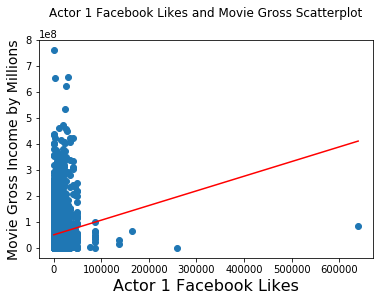

In [52]:
#Scatterplot for actor1_facebook_likes and movie gross with regression line
#max actor_1 likes
max_actor1_likes = int(movies_df.actor_1_facebook_likes.max())

a1, b1 = np.polyfit(movies_df.actor_1_facebook_likes, movies_df.gross, 1)

pred_likes1_list = list()
for i in range(0, max_actor1_likes):
    pred_likes1_list.append((a1 * i) + b1)

pred_likes1 = np.array(pred_likes1_list)

plt.scatter(movies_df.actor_1_facebook_likes, movies_df.gross)

plt.plot(range(0, max_actor1_likes), pred_likes1, color='red')

plt.xlabel('Actor 1 Facebook Likes', fontsize = 16)
plt.ylabel('Movie Gross Income by Millions', fontsize = 14)
plt.title('Actor 1 Facebook Likes and Movie Gross Scatterplot', y=1.08)

Text(0.5, 1.08, 'Actor 2 Facebook Likes and Movie Gross Scatterplot')

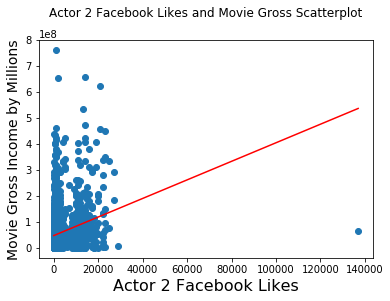

In [53]:
#Scatterplot for actor2_facebook_likes and movie gross with regression line
#max actor_2 likes
max_actor2_likes = int(movies_df.actor_2_facebook_likes.max())

a2, b2 = np.polyfit(movies_df.actor_2_facebook_likes, movies_df.gross, 1)

pred_likes2_list = list()
for i in range(0, max_actor2_likes):
    pred_likes2_list.append((a2 * i) + b2)

pred_likes2 = np.array(pred_likes2_list)

plt.scatter(movies_df.actor_2_facebook_likes, movies_df.gross)

plt.plot(range(0, max_actor2_likes), pred_likes2, color='red')

plt.xlabel('Actor 2 Facebook Likes', fontsize = 16)
plt.ylabel('Movie Gross Income by Millions', fontsize = 14)
plt.title('Actor 2 Facebook Likes and Movie Gross Scatterplot', y=1.08)

Text(0.5, 1.08, 'Actor 3 Facebook Likes and Movie Gross Scatterplot')

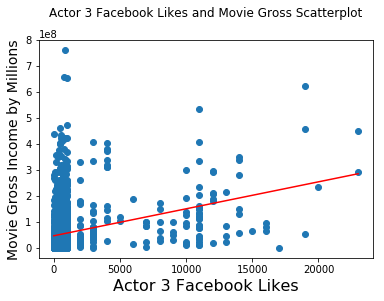

In [54]:
#Scatterplot for actor3_facebook_likes and movie gross with regression line
#max actor_3 likes
max_actor3_likes = int(movies_df.actor_3_facebook_likes.max())

a3, b3 = np.polyfit(movies_df.actor_3_facebook_likes, movies_df.gross, 1)

pred_likes3_list = list()
for i in range(0, max_actor3_likes):
    pred_likes3_list.append((a3 * i) + b3)

pred_likes3 = np.array(pred_likes3_list)

plt.scatter(movies_df.actor_3_facebook_likes, movies_df.gross)

plt.plot(range(0, max_actor3_likes), pred_likes3, color='red')

plt.xlabel('Actor 3 Facebook Likes', fontsize = 16)
plt.ylabel('Movie Gross Income by Millions', fontsize = 14)
plt.title('Actor 3 Facebook Likes and Movie Gross Scatterplot', y=1.08)

Text(0.5, 1.08, 'Director Facebook Likes and Movie Gross Scatterplot')

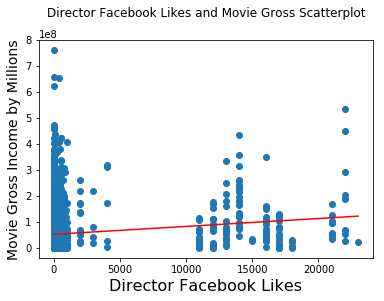

In [55]:
#Scatterplot for director_facebook_likes and movie gross with regression line
#max director likes
max_director_likes = int(movies_df.director_facebook_likes.max())

a, b = np.polyfit(movies_df.director_facebook_likes, movies_df.gross, 1)

pred_likes_list = list()
for i in range(0, max_director_likes):
    pred_likes_list.append((a * i) + b)

pred_likes = np.array(pred_likes_list)

plt.scatter(movies_df.director_facebook_likes, movies_df.gross)

plt.plot(range(0, max_director_likes), pred_likes, color='red')

plt.xlabel('Director Facebook Likes', fontsize = 16)
plt.ylabel('Movie Gross Income by Millions', fontsize = 14)
plt.title('Director Facebook Likes and Movie Gross Scatterplot', y=1.08)

The scatterplots demonstrate a positive correlation between facebook likes and movie gross income. However, the distributions are clustered and therefore need to be transformed for a desired normal distribution.. From this, we decided to use a log transformation.

In [19]:
#having any 0 likes affects log transformation
movies_df[(movies_df.actor_1_facebook_likes == 0) |
          (movies_df.actor_2_facebook_likes == 0) |
          (movies_df.actor_3_facebook_likes == 0) |
          (movies_df.director_facebook_likes == 0)].count()

movie_title                550
title_year                 550
gross                      550
director_name              550
director_facebook_likes    550
actor_1_name               550
                          ... 
Horror                     550
Biography                  550
Mystery                    550
War                        550
Music                      550
Documentary                550
Length: 33, dtype: int64

In [20]:
#add .1 weight to all likes
movies_df.actor_1_facebook_likes = (
    movies_df.actor_1_facebook_likes.apply(lambda x: x+.1))
movies_df.actor_2_facebook_likes = (
    movies_df.actor_2_facebook_likes.apply(lambda x: x+.1))
movies_df.actor_3_facebook_likes = (
    movies_df.actor_3_facebook_likes.apply(lambda x: x+.1))
movies_df.director_facebook_likes = (
    movies_df.director_facebook_likes.apply(lambda x: x+.1))

Text(0.5, 1.08, 'Actor 1 Facebook Likes and Movie Gross Scatterplot')

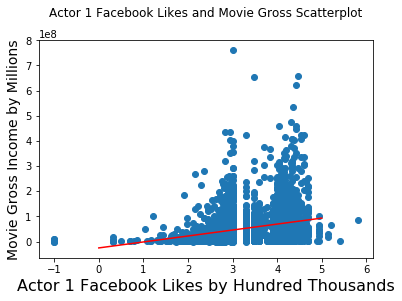

In [56]:
#Changing like values of actor 1 using log10
movies_df['actor_1_facebook_likes_log'] = (
    np.log10(movies_df['actor_1_facebook_likes']))

#Scatterplot for actor1_facebook_likes and movie gross with regression line
#max actor_1 likes
max_logactor1_likes = movies_df.actor_1_facebook_likes_log.max()

a1, b1 = (
    np.polyfit(movies_df.actor_1_facebook_likes_log, movies_df.gross, 1))

pred_loglikes1_list = list()
for i in np.arange(0, max_logactor1_likes):
    pred_loglikes1_list.append((a1 * i) + b1)

pred_loglikes1 = np.array(pred_loglikes1_list)

plt.scatter(movies_df.actor_1_facebook_likes_log, movies_df.gross)

plt.plot(np.arange(0, max_logactor1_likes), pred_loglikes1, color='red')

plt.xlabel('Actor 1 Facebook Likes by Hundred Thousands', fontsize = 16)
plt.ylabel('Movie Gross Income by Millions', fontsize = 14)
plt.title('Actor 1 Facebook Likes and Movie Gross Scatterplot', y=1.08)

The log transformation has an effect on increasing the r-value. There is a slight increase in the
correlation between likes to gross income. However, the correlation is still substantially weak.

In [22]:
#stats for actor 1 likes with gross
slope1, intercept1, r1_value, p1_value, std_err = (
    stats.linregress(movies_df['actor_1_facebook_likes'],
                     movies_df['gross']))
print(r1_value)
slope1, intercept1, r1_value, p1_value, std_err = (
    stats.linregress(movies_df['actor_1_facebook_likes_log'],
                     movies_df['gross']))
print(r1_value)

0.1312265665513149
0.2489085388174903


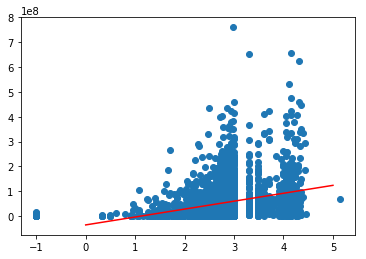

In [23]:
#Changing like values of actor 2 using log10
movies_df['actor_2_facebook_likes_log'] = (
    np.log10(movies_df['actor_2_facebook_likes']))

#Scatterplot for actor1_facebook_likes and movie gross with regression line
#max actor_1 likes
max_logactor2_likes = movies_df.actor_2_facebook_likes_log.max()

a2, b2 = (
    np.polyfit(movies_df.actor_2_facebook_likes_log, movies_df.gross, 1))

pred_loglikes2_list = list()
for i in np.arange(0, max_logactor2_likes):
    pred_loglikes2_list.append((a2 * i) + b2)

pred_loglikes2 = np.array(pred_loglikes2_list)

plt.scatter(movies_df.actor_2_facebook_likes_log, movies_df.gross)

plt.plot(np.arange(0, max_logactor2_likes), pred_loglikes2, color='red')

In [24]:
#stats for actor 2 likes with gross
slope2, intercept2, r2_value, p2_value, std_err = (
    stats.linregress(movies_df['actor_2_facebook_likes'],
                     movies_df['gross']))
print(r2_value)
slope2, intercept2, r2_value, p2_value, std_err = (
    stats.linregress(movies_df['actor_2_facebook_likes_log'],
                     movies_df['gross']))
print(r2_value)

0.23465147465274078
0.28477527226635774


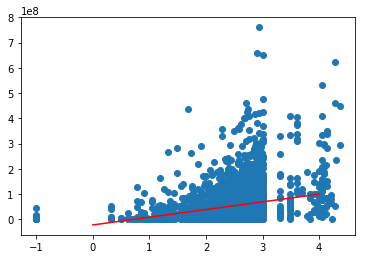

In [25]:
#Changing like values of actor 3 using log10
movies_df['actor_3_facebook_likes_log'] = (
    np.log10(movies_df['actor_3_facebook_likes']))

#Scatterplot for actor1_facebook_likes and movie gross with regression line
#max actor_1 likes
max_logactor3_likes = movies_df.actor_3_facebook_likes_log.max()

a3, b3 = (
    np.polyfit(movies_df.actor_3_facebook_likes_log, movies_df.gross, 1))

pred_loglikes3_list = list()
for i in np.arange(0, max_logactor3_likes):
    pred_loglikes3_list.append((a3 * i) + b3)

pred_loglikes3 = np.array(pred_loglikes3_list)

plt.scatter(movies_df.actor_3_facebook_likes_log, movies_df.gross)

plt.plot(np.arange(0, max_logactor3_likes), pred_loglikes3, color='red')

In [26]:
#stats for actor 3 likes with gross
slope3, intercept1, r3_value, p3_value, std_err = (
    stats.linregress(movies_df['actor_3_facebook_likes'],
                     movies_df['gross']))
print(r3_value)
slope3, intercept1, r3_value, p3_value, std_err = (
    stats.linregress(movies_df['actor_3_facebook_likes_log'],
                     movies_df['gross']))
print(r3_value)

0.2770023668785392
0.2630527011471118


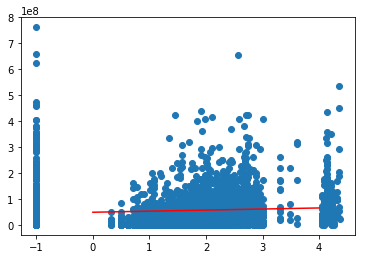

In [27]:
#Changing like values of director likes using log10
movies_df['director_facebook_likes_log'] = (
    np.log10(movies_df['director_facebook_likes']))

#Scatterplot for actor1_facebook_likes and movie gross with regression line
#max actor_1 likes
max_logdirector_likes = movies_df.director_facebook_likes_log.max()

a, b = (
    np.polyfit(movies_df.director_facebook_likes_log, movies_df.gross, 1))

pred_loglikes_list = list()
for i in np.arange(0, max_logdirector_likes):
    pred_loglikes_list.append((a * i) + b)

pred_loglikes = np.array(pred_loglikes_list)

plt.scatter(movies_df.director_facebook_likes_log, movies_df.gross)

plt.plot(np.arange(0, max_logdirector_likes), pred_loglikes, color='red')

In [28]:
#stats for director likes with gross
slope, intercept, r_value, p_value, std_err = (
    stats.linregress(movies_df['director_facebook_likes'],
                     movies_df['gross']))
print(r_value)
slope, intercept, r_value, p_value, std_err = (
    stats.linregress(movies_df['director_facebook_likes_log'],
                     movies_df['gross']))
print(r_value)

0.14059768143149814
0.07842459804293193


[Text(0, 0, 'Action'),
 Text(0, 0, 'Adventure'),
 Text(0, 0, 'Fantasy'),
 Text(0, 0, 'Sci-Fi'),
 Text(0, 0, 'Thriller'),
 Text(0, 0, 'Romance'),
 Text(0, 0, 'Animation'),
 Text(0, 0, 'Comedy'),
 Text(0, 0, 'Family'),
 Text(0, 0, 'Musical'),
 Text(0, 0, 'Western'),
 Text(0, 0, 'Drama'),
 Text(0, 0, 'History'),
 Text(0, 0, 'Sport'),
 Text(0, 0, 'Crime'),
 Text(0, 0, 'Horror'),
 Text(0, 0, 'Biography'),
 Text(0, 0, 'Mystery'),
 Text(0, 0, 'War'),
 Text(0, 0, 'Music'),
 Text(0, 0, 'Documentary')]

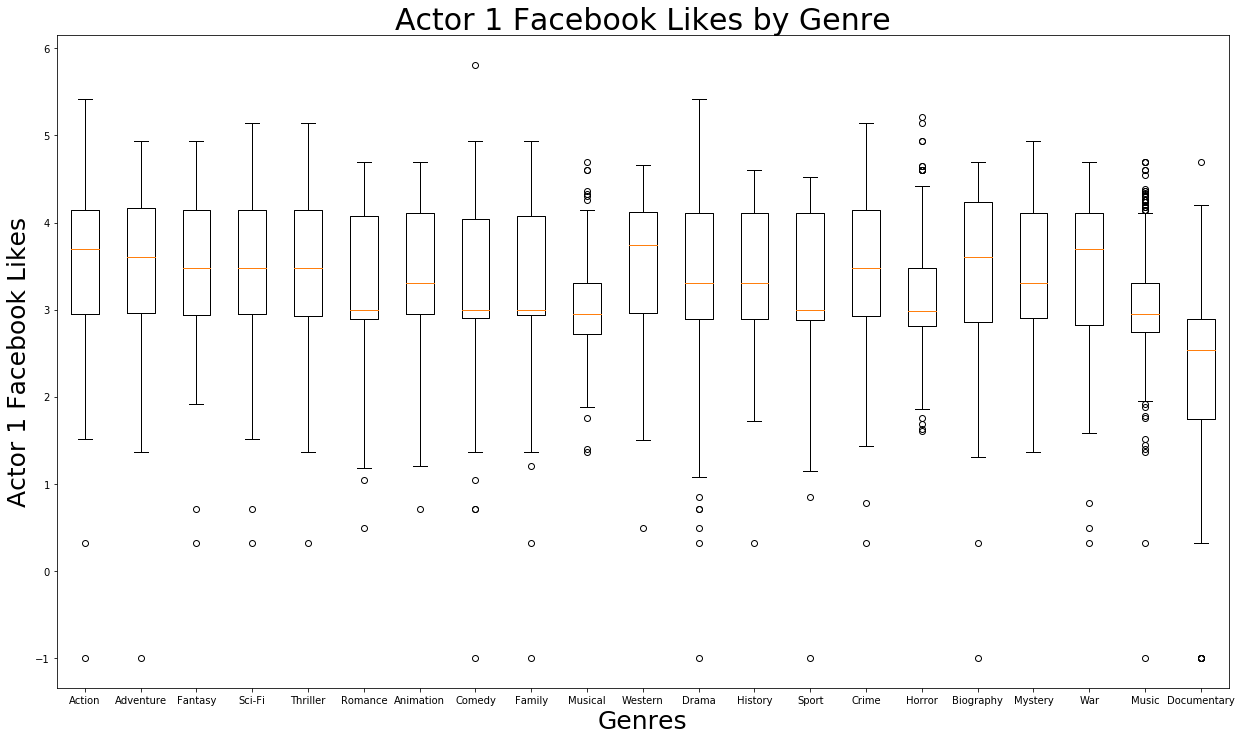

In [29]:
#Add all actor1 likes into its respective list

action1 = []
adventure1 = []
fantasy1 = []
scifi1 = []
thriller1 = []
romance1 = []
animation1 = []
comedy1 = []
family1 = []
musical1 = []
western1 = []
drama1 = []
history1 = []
sport1 = []
crime1 = []
horror1 = []
biography1 = []
mystery1 = []
war1 = []
music1 = []
documentary1 = []


for i, rows in movies_df.iterrows():
    currLikes = rows['actor_1_facebook_likes_log']
    if (rows['genres'].find('Action') >= 0):
        action1.append(currLikes)
    if (rows['genres'].find('Adventure') >= 0):
        adventure1.append(currLikes)
    if (rows['genres'].find('Fantasy') >= 0):
        fantasy1.append(currLikes)
    if (rows['genres'].find('Sci-Fi') >= 0):
        scifi1.append(currLikes)
    if (rows['genres'].find('Thriller') >= 0):
        thriller1.append(currLikes)
    if (rows['genres'].find('Romance') >= 0):
        romance1.append(currLikes)
    if (rows['genres'].find('Animation') >= 0):
        animation1.append(currLikes)
    if (rows['genres'].find('Comedy') >= 0):
        comedy1.append(currLikes)
    if (rows['genres'].find('Family') >= 0):
        family1.append(currLikes)
    if (rows['genres'].find('Musical') >= 0):
        musical1.append(currLikes)
    if (rows['genres'].find('Western') >= 0):
        western1.append(currLikes)
    if (rows['genres'].find('Drama') >= 0):
        drama1.append(currLikes)
    if (rows['genres'].find('History') >= 0):
        history1.append(currLikes)
    if (rows['genres'].find('Sport') >= 0):
        sport1.append(currLikes)
    if (rows['genres'].find('Crime') >= 0):
        crime1.append(currLikes)
    if (rows['genres'].find('Horror') >= 0):
        horror1.append(currLikes)
    if (rows['genres'].find('Biography') >= 0):
        biography1.append(currLikes)
    if (rows['genres'].find('Mystery') >= 0):
        mystery1.append(currLikes)
    if (rows['genres'].find('War') >= 0):
        war1.append(currLikes)
    if (rows['genres'].find('Music') >= 0):
        music1.append(currLikes)
    if (rows['genres'].find('Documentary') >= 0):
        documentary1.append(currLikes)
        
        
actor1Likes = [action1, adventure1, fantasy1, scifi1, thriller1, romance1, animation1,
               comedy1,family1 ,musical1 ,western1, drama1, history1 , sport1 , crime1 ,
               horror1, biography1 , mystery1 , war1 , music1 ,documentary1]

fig = plt.figure(1, figsize=(21, 12))

ax = fig.add_subplot(111)

bp = plt.boxplot(actor1Likes)

ax.set_title('Actor 1 Facebook Likes by Genre', fontsize=30)
ax.set_xlabel('Genres', fontsize=25)
ax.set_ylabel('Actor 1 Facebook Likes', fontsize=25)
ax.set_xticklabels(
           ["Action","Adventure","Fantasy", "Sci-Fi", "Thriller", "Romance",
            "Animation", "Comedy", "Family", "Musical", "Western", "Drama", "History",
            "Sport", "Crime", "Horror", "Biography", "Mystery", "War", "Music", "Documentary"])

[Text(0, 0, 'Action'),
 Text(0, 0, 'Adventure'),
 Text(0, 0, 'Fantasy'),
 Text(0, 0, 'Sci-Fi'),
 Text(0, 0, 'Thriller'),
 Text(0, 0, 'Romance'),
 Text(0, 0, 'Animation'),
 Text(0, 0, 'Comedy'),
 Text(0, 0, 'Family'),
 Text(0, 0, 'Musical'),
 Text(0, 0, 'Western'),
 Text(0, 0, 'Drama'),
 Text(0, 0, 'History'),
 Text(0, 0, 'Sport'),
 Text(0, 0, 'Crime'),
 Text(0, 0, 'Horror'),
 Text(0, 0, 'Biography'),
 Text(0, 0, 'Mystery'),
 Text(0, 0, 'War'),
 Text(0, 0, 'Music'),
 Text(0, 0, 'Documentary')]

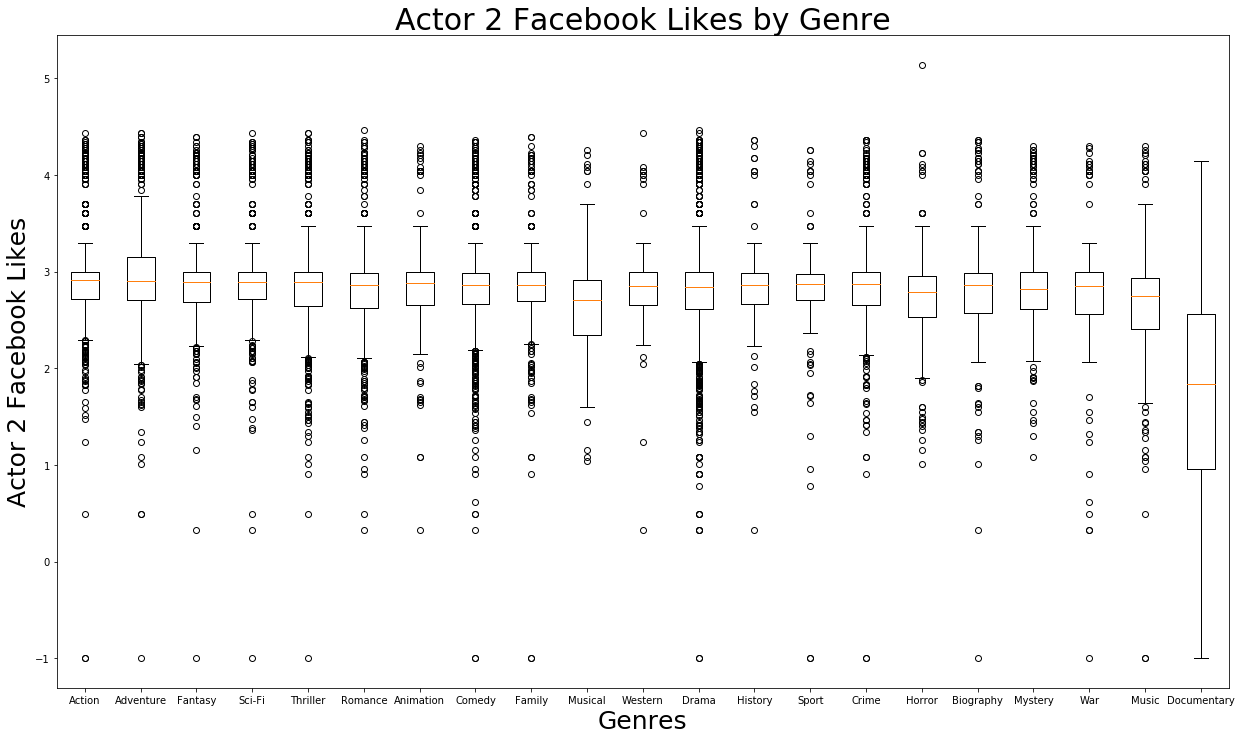

In [30]:
#Add all actor2 likes into its respective list

action2 = []
adventure2 = []
fantasy2 = []
scifi2 = []
thriller2 = []
romance2 = []
animation2 = []
comedy2 = []
family2 = []
musical2 = []
western2 = []
drama2 = []
history2 = []
sport2 = []
crime2 = []
horror2 = []
biography2 = []
mystery2 = []
war2 = []
music2 = []
documentary2 = []


for i, rows in movies_df.iterrows():
    currLikes = rows['actor_2_facebook_likes_log']
    if (rows['genres'].find('Action') >= 0):
        action2.append(currLikes)
    if (rows['genres'].find('Adventure') >= 0):
        adventure2.append(currLikes)
    if (rows['genres'].find('Fantasy') >= 0):
        fantasy2.append(currLikes)
    if (rows['genres'].find('Sci-Fi') >= 0):
        scifi2.append(currLikes)
    if (rows['genres'].find('Thriller') >= 0):
        thriller2.append(currLikes)
    if (rows['genres'].find('Romance') >= 0):
        romance2.append(currLikes)
    if (rows['genres'].find('Animation') >= 0):
        animation2.append(currLikes)
    if (rows['genres'].find('Comedy') >= 0):
        comedy2.append(currLikes)
    if (rows['genres'].find('Family') >= 0):
        family2.append(currLikes)
    if (rows['genres'].find('Musical') >= 0):
        musical2.append(currLikes)
    if (rows['genres'].find('Western') >= 0):
        western2.append(currLikes)
    if (rows['genres'].find('Drama') >= 0):
        drama2.append(currLikes)
    if (rows['genres'].find('History') >= 0):
        history2.append(currLikes)
    if (rows['genres'].find('Sport') >= 0):
        sport2.append(currLikes)
    if (rows['genres'].find('Crime') >= 0):
        crime2.append(currLikes)
    if (rows['genres'].find('Horror') >= 0):
        horror2.append(currLikes)
    if (rows['genres'].find('Biography') >= 0):
        biography2.append(currLikes)
    if (rows['genres'].find('Mystery') >= 0):
        mystery2.append(currLikes)
    if (rows['genres'].find('War') >= 0):
        war2.append(currLikes)
    if (rows['genres'].find('Music') >= 0):
        music2.append(currLikes)
    if (rows['genres'].find('Documentary') >= 0):
        documentary2.append(currLikes)
        
        
actor2Likes = [action2, adventure2, fantasy2, scifi2, thriller2, romance2, animation2,
               comedy2,family2 ,musical2 ,western2, drama2, history2 , sport2 , crime2 ,
               horror2, biography2 , mystery2 , war2 , music2 ,documentary2]

fig = plt.figure(1, figsize=(21, 12))

ax = fig.add_subplot(111)

bp = ax.boxplot(actor2Likes)

ax.set_title('Actor 2 Facebook Likes by Genre', fontsize=30)
ax.set_xlabel('Genres', fontsize=25)
ax.set_ylabel('Actor 2 Facebook Likes', fontsize=25)
ax.set_xticklabels(
           ["Action","Adventure","Fantasy", "Sci-Fi", "Thriller", "Romance",
            "Animation", "Comedy", "Family", "Musical", "Western", "Drama", "History",
            "Sport", "Crime", "Horror", "Biography", "Mystery", "War", "Music", "Documentary"])

[Text(0, 0, 'Action'),
 Text(0, 0, 'Adventure'),
 Text(0, 0, 'Fantasy'),
 Text(0, 0, 'Sci-Fi'),
 Text(0, 0, 'Thriller'),
 Text(0, 0, 'Romance'),
 Text(0, 0, 'Animation'),
 Text(0, 0, 'Comedy'),
 Text(0, 0, 'Family'),
 Text(0, 0, 'Musical'),
 Text(0, 0, 'Western'),
 Text(0, 0, 'Drama'),
 Text(0, 0, 'History'),
 Text(0, 0, 'Sport'),
 Text(0, 0, 'Crime'),
 Text(0, 0, 'Horror'),
 Text(0, 0, 'Biography'),
 Text(0, 0, 'Mystery'),
 Text(0, 0, 'War'),
 Text(0, 0, 'Music'),
 Text(0, 0, 'Documentary')]

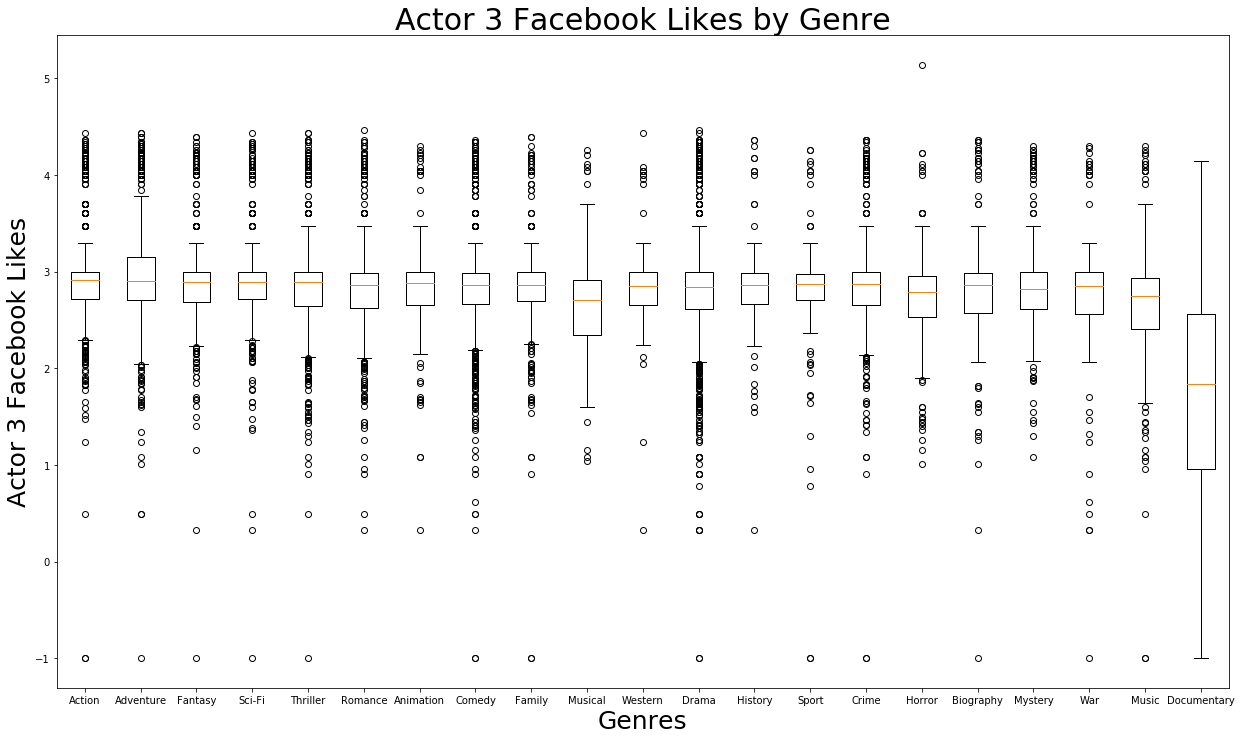

In [31]:
#Add all actor3 likes into its respective list

action3 = []
adventure3 = []
fantasy3 = []
scifi3 = []
thriller3 = []
romance3 = []
animation3 = []
comedy3 = []
family3 = []
musical3 = []
western3 = []
drama3 = []
history3 = []
sport3 = []
crime3 = []
horror3 = []
biography3 = []
mystery3 = []
war3 = []
music3 = []
documentary3 = []


for i, rows in movies_df.iterrows():
    currLikes = rows['actor_3_facebook_likes_log']
    if (rows['genres'].find('Action') >= 0):
        action3.append(currLikes)
    if (rows['genres'].find('Adventure') >= 0):
        adventure3.append(currLikes)
    if (rows['genres'].find('Fantasy') >= 0):
        fantasy3.append(currLikes)
    if (rows['genres'].find('Sci-Fi') >= 0):
        scifi3.append(currLikes)
    if (rows['genres'].find('Thriller') >= 0):
        thriller3.append(currLikes)
    if (rows['genres'].find('Romance') >= 0):
        romance3.append(currLikes)
    if (rows['genres'].find('Animation') >= 0):
        animation3.append(currLikes)
    if (rows['genres'].find('Comedy') >= 0):
        comedy3.append(currLikes)
    if (rows['genres'].find('Family') >= 0):
        family3.append(currLikes)
    if (rows['genres'].find('Musical') >= 0):
        musical3.append(currLikes)
    if (rows['genres'].find('Western') >= 0):
        western3.append(currLikes)
    if (rows['genres'].find('Drama') >= 0):
        drama3.append(currLikes)
    if (rows['genres'].find('History') >= 0):
        history3.append(currLikes)
    if (rows['genres'].find('Sport') >= 0):
        sport3.append(currLikes)
    if (rows['genres'].find('Crime') >= 0):
        crime3.append(currLikes)
    if (rows['genres'].find('Horror') >= 0):
        horror3.append(currLikes)
    if (rows['genres'].find('Biography') >= 0):
        biography3.append(currLikes)
    if (rows['genres'].find('Mystery') >= 0):
        mystery3.append(currLikes)
    if (rows['genres'].find('War') >= 0):
        war3.append(currLikes)
    if (rows['genres'].find('Music') >= 0):
        music3.append(currLikes)
    if (rows['genres'].find('Documentary') >= 0):
        documentary3.append(currLikes)
        
        
actor3Likes = [action3, adventure3, fantasy3, scifi3, thriller3, romance3, animation3,
               comedy3,family3 ,musical3 ,western3, drama3, history3 , sport3 , crime3 ,
               horror3, biography3 , mystery3 , war3 , music3 ,documentary3]

fig = plt.figure(1, figsize=(21, 12))

ax = fig.add_subplot(111)

bp = ax.boxplot(actor2Likes)

ax.set_title('Actor 3 Facebook Likes by Genre', fontsize=30)
ax.set_xlabel('Genres', fontsize=25)
ax.set_ylabel('Actor 3 Facebook Likes', fontsize=25)
ax.set_xticklabels(
           ["Action","Adventure","Fantasy", "Sci-Fi", "Thriller", "Romance",
            "Animation", "Comedy", "Family", "Musical", "Western", "Drama", "History",
            "Sport", "Crime", "Horror", "Biography", "Mystery", "War", "Music", "Documentary"])

[Text(0, 0, 'Action'),
 Text(0, 0, 'Adventure'),
 Text(0, 0, 'Fantasy'),
 Text(0, 0, 'Sci-Fi'),
 Text(0, 0, 'Thriller'),
 Text(0, 0, 'Romance'),
 Text(0, 0, 'Animation'),
 Text(0, 0, 'Comedy'),
 Text(0, 0, 'Family'),
 Text(0, 0, 'Musical'),
 Text(0, 0, 'Western'),
 Text(0, 0, 'Drama'),
 Text(0, 0, 'History'),
 Text(0, 0, 'Sport'),
 Text(0, 0, 'Crime'),
 Text(0, 0, 'Horror'),
 Text(0, 0, 'Biography'),
 Text(0, 0, 'Mystery'),
 Text(0, 0, 'War'),
 Text(0, 0, 'Music'),
 Text(0, 0, 'Documentary')]

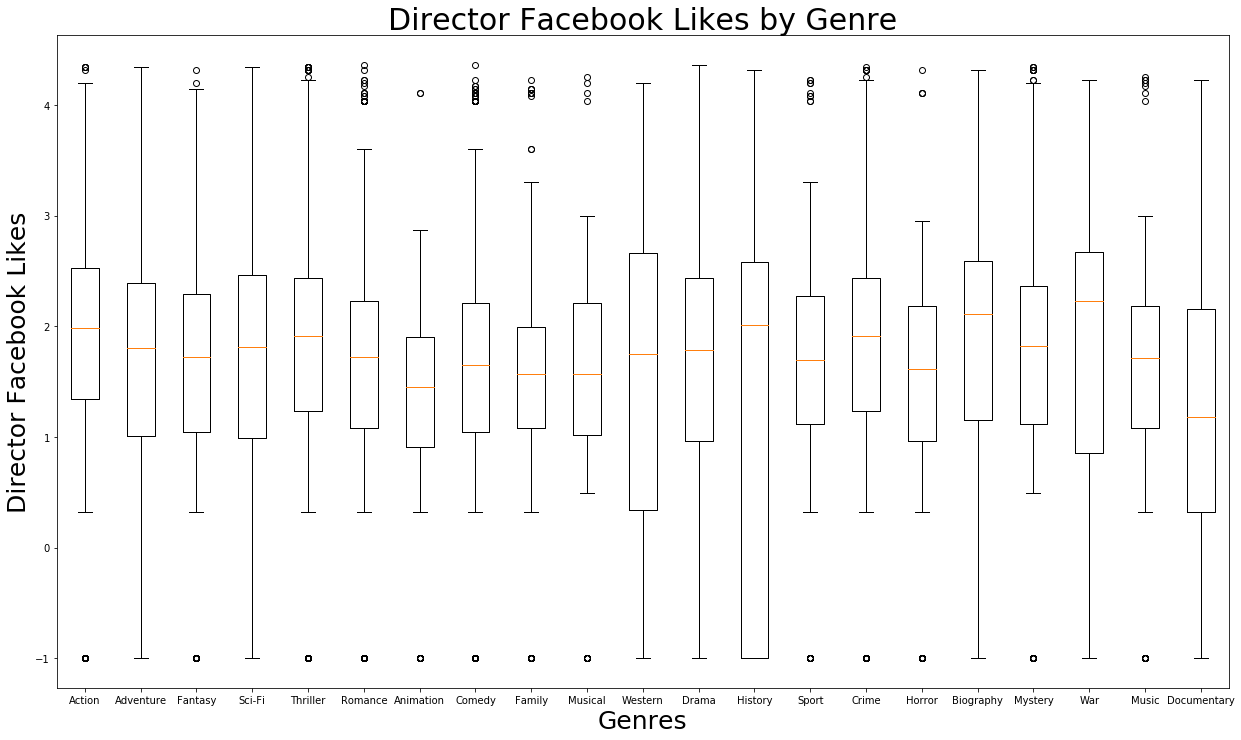

In [32]:
#Add all actor1 likes into its respective list

actionD = []
adventureD = []
fantasyD = []
scifiD = []
thrillerD = []
romanceD = []
animationD = []
comedyD = []
familyD = []
musicalD = []
westernD = []
dramaD = []
historyD = []
sportD = []
crimeD = []
horrorD = []
biographyD = []
mysteryD = []
warD = []
musicD = []
documentaryD = []


for i, rows in movies_df.iterrows():
    currLikes = rows['director_facebook_likes_log']
    if (rows['genres'].find('Action') >= 0):
        actionD.append(currLikes)
    if (rows['genres'].find('Adventure') >= 0):
        adventureD.append(currLikes)
    if (rows['genres'].find('Fantasy') >= 0):
        fantasyD.append(currLikes)
    if (rows['genres'].find('Sci-Fi') >= 0):
        scifiD.append(currLikes)
    if (rows['genres'].find('Thriller') >= 0):
        thrillerD.append(currLikes)
    if (rows['genres'].find('Romance') >= 0):
        romanceD.append(currLikes)
    if (rows['genres'].find('Animation') >= 0):
        animationD.append(currLikes)
    if (rows['genres'].find('Comedy') >= 0):
        comedyD.append(currLikes)
    if (rows['genres'].find('Family') >= 0):
        familyD.append(currLikes)
    if (rows['genres'].find('Musical') >= 0):
        musicalD.append(currLikes)
    if (rows['genres'].find('Western') >= 0):
        westernD.append(currLikes)
    if (rows['genres'].find('Drama') >= 0):
        dramaD.append(currLikes)
    if (rows['genres'].find('History') >= 0):
        historyD.append(currLikes)
    if (rows['genres'].find('Sport') >= 0):
        sportD.append(currLikes)
    if (rows['genres'].find('Crime') >= 0):
        crimeD.append(currLikes)
    if (rows['genres'].find('Horror') >= 0):
        horrorD.append(currLikes)
    if (rows['genres'].find('Biography') >= 0):
        biographyD.append(currLikes)
    if (rows['genres'].find('Mystery') >= 0):
        mysteryD.append(currLikes)
    if (rows['genres'].find('War') >= 0):
        warD.append(currLikes)
    if (rows['genres'].find('Music') >= 0):
        musicD.append(currLikes)
    if (rows['genres'].find('Documentary') >= 0):
        documentaryD.append(currLikes)
        
        
actorDLikes = [actionD, adventureD, fantasyD, scifiD, thrillerD, romanceD, animationD,
               comedyD,familyD ,musicalD ,westernD, dramaD, historyD , sportD , crimeD ,
               horrorD, biographyD , mysteryD , warD , musicD ,documentaryD]

fig = plt.figure(1, figsize=(21, 12))

ax = fig.add_subplot(111)

bp = plt.boxplot(actorDLikes)

ax.set_title('Director Facebook Likes by Genre', fontsize=30)
ax.set_xlabel('Genres', fontsize=25)
ax.set_ylabel('Director Facebook Likes', fontsize=25)
ax.set_xticklabels(
           ["Action","Adventure","Fantasy", "Sci-Fi", "Thriller", "Romance",
            "Animation", "Comedy", "Family", "Musical", "Western", "Drama", "History",
            "Sport", "Crime", "Horror", "Biography", "Mystery", "War", "Music", "Documentary"])

In [33]:
#Regression Model for actor 1 likes to predict gross income of movie
outcome_1, predictors_1 = (
    patsy.dmatrices('gross ~ actor_1_facebook_likes_log', movies_df))
mod_1 = sm.OLS (outcome_1,predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     205.8
Date:                Sun, 09 Jun 2019   Prob (F-statistic):           3.03e-45
Time:                        20:24:00   Log-Likelihood:                -60699.
No. Observations:                3118   AIC:                         1.214e+05
Df Residuals:                    3116   BIC:                         1.214e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [34]:
#Regression Model for actor 1 likes with genres to predict gross income of movie
outcome_1, predictors_1 = (
    patsy.dmatrices('gross ~ actor_1_facebook_likes_log + Action + Adventure + '
                    'Fantasy + Scifi + Thriller + Romance + Animation + Comedy + '
                    'Family + Musical + Western + Drama + History + Sport + Crime + '
                    'Horror + Biography + Mystery + War + Music + Documentary', movies_df))
mod_1 = sm.OLS (outcome_1,predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     43.30
Date:                Sun, 09 Jun 2019   Prob (F-statistic):          5.65e-162
Time:                        20:24:00   Log-Likelihood:                -60381.
No. Observations:                3118   AIC:                         1.208e+05
Df Residuals:                    3095   BIC:                         1.209e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [35]:
#Regression Model for actor 2 likes to predict gross income of movie
outcome_2, predictors_2 = (
    patsy.dmatrices('gross ~ actor_2_facebook_likes_log', movies_df))
mod_2 = sm.OLS (outcome_2,predictors_2)
res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     275.0
Date:                Sun, 09 Jun 2019   Prob (F-statistic):           2.97e-59
Time:                        20:24:00   Log-Likelihood:                -60667.
No. Observations:                3118   AIC:                         1.213e+05
Df Residuals:                    3116   BIC:                         1.214e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [36]:
#Regression Model for actor 2 likes with genres to predict gross income of movie
outcome_2, predictors_2 = (
    patsy.dmatrices('gross ~ actor_2_facebook_likes_log + Action + Adventure + '
                    'Fantasy + Scifi + Thriller + Romance + Animation + Comedy + '
                    'Family + Musical + Western + Drama + History + Sport + Crime + '
                    'Horror + Biography + Mystery + War + Music + Documentary', movies_df))
mod_2 = sm.OLS (outcome_2,predictors_2)
res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     46.99
Date:                Sun, 09 Jun 2019   Prob (F-statistic):          4.58e-175
Time:                        20:24:00   Log-Likelihood:                -60350.
No. Observations:                3118   AIC:                         1.207e+05
Df Residuals:                    3095   BIC:                         1.209e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [37]:
#Regression Model for actor 3 likes to predict gross income of movie
outcome_3, predictors_3 = (
    patsy.dmatrices('gross ~ actor_3_facebook_likes_log', movies_df))
mod_3 = sm.OLS (outcome_3,predictors_3)
res_3 = mod_3.fit()
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     231.6
Date:                Sun, 09 Jun 2019   Prob (F-statistic):           1.64e-50
Time:                        20:24:00   Log-Likelihood:                -60687.
No. Observations:                3118   AIC:                         1.214e+05
Df Residuals:                    3116   BIC:                         1.214e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [38]:
#Regression Model for actor 3 likes with genres to predict gross income of movie
outcome_3, predictors_3 = (
    patsy.dmatrices('gross ~ actor_3_facebook_likes_log + Action + Adventure + '
                    'Fantasy + Scifi + Thriller + Romance + Animation + Comedy + '
                    'Family + Musical + Western + Drama + History + Sport + Crime + '
                    'Horror + Biography + Mystery + War + Music + Documentary', movies_df))
mod_3 = sm.OLS (outcome_3,predictors_3)
res_3 = mod_3.fit()
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     44.24
Date:                Sun, 09 Jun 2019   Prob (F-statistic):          2.42e-165
Time:                        20:24:00   Log-Likelihood:                -60373.
No. Observations:                3118   AIC:                         1.208e+05
Df Residuals:                    3095   BIC:                         1.209e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [39]:
#Regression Model for all actor likes to predict gross income of movie
outcome_ag, predictors_ag = (
    patsy.dmatrices('gross ~ actor_1_facebook_likes_log + '
                    'actor_2_facebook_likes_log + '
                    'actor_3_facebook_likes_log', movies_df))
mod_ag = sm.OLS (outcome_ag,predictors_ag)
res_ag = mod_ag.fit()
print(res_ag.summary())

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     100.6
Date:                Sun, 09 Jun 2019   Prob (F-statistic):           3.77e-62
Time:                        20:24:00   Log-Likelihood:                -60655.
No. Observations:                3118   AIC:                         1.213e+05
Df Residuals:                    3114   BIC:                         1.213e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [40]:
#Regression Model for director likes to predict gross income of movie
outcome, predictors = (
    patsy.dmatrices('gross ~ director_facebook_likes_log', movies_df))
mod = sm.OLS (outcome,predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     19.28
Date:                Sun, 09 Jun 2019   Prob (F-statistic):           1.16e-05
Time:                        20:24:00   Log-Likelihood:                -60789.
No. Observations:                3118   AIC:                         1.216e+05
Df Residuals:                    3116   BIC:                         1.216e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [41]:
#Regression Model for director likes with genres to predict gross income of movie
outcome, predictors = (
    patsy.dmatrices('gross ~ director_facebook_likes_log + Action + Adventure + '
                    'Fantasy + Scifi + Thriller + Romance + Animation + Comedy + '
                    'Family + Musical + Western + Drama + History + Sport + Crime + '
                    'Horror + Biography + Mystery + War + Music + Documentary', movies_df))
mod = sm.OLS (outcome,predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     35.79
Date:                Sun, 09 Jun 2019   Prob (F-statistic):          1.24e-134
Time:                        20:24:01   Log-Likelihood:                -60445.
No. Observations:                3118   AIC:                         1.209e+05
Df Residuals:                    3095   BIC:                         1.211e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

### Ethics and Privacy Considerations
The dataset has some issues of certain facebook likes where certain actors and directors have incorrect listings. For example, the director Spike Lee within the dataset had a listing of 0 facebook likes. However, future observation displayed an official facebook page with 765,000 likes. In addition, we observed duplicate indexed movies in the data set that have inconsistent entries in cast likes as well as number voted users. Although our observation of the data does not include this column, the fact that there are inconsistencies in the first place leads to some doubts about the dataset as a whole. As a result, this potentiates the issue of false data which would give way to incorrect predictions and assessments.

In regards to the method in which the data was collected, we do not know for sure as the dataset does not explain their process in cataloging information. However, we have reason to believe that privacy is not infringed upon as most of the information that we will focus on is made public on either IMDb and Facebook. Since we are focusing on Facebook likes, we believe that the potential privacy issues is relatively low as they are metrics generated anonymously. The dataset is also made public on kaggle, a dataset sharing website. 

### Conclusion & Discussion
From observing the regression models, each prediction instance has a low p-value meaning there is a significance to their inclusion in the model. However, the model itself accounts for very little variation demonstrated by the low r-squared. This is mostly explained due to the bimodal distribution of actor and director likes which causes a strict model to form. From this, we conclude that models generated from actor and director Facebook likes serve as poor indicators for a movie’s gross income. Therefore, we reject our hypothesis and posit that there is no correlation of FB likes of actors and directors to a movie’s gross income which is further identified in the low r-values in our scatterplots. In addition, there are confounding variables that influence both likes and gross income such as advertisement or the movie’s release date. Advertisement can bring consumers to movies as well as interest in the actors in the movie. A movie’s release date changes the rate in which consumers are likely to watch movies such as during vacation breaks. These confounding variables could have contributed in the distribution of likes as well.

If we had any further resources and time to continue this project, we would have liked other measurements to observe social media presence such as Instagram and Twitter. To coincide the need for better dataset information, we would like the dataset to be updated to relieve rounding as well as inconsistencies. For future use, updates to new releases since the original posting would allow for further observations.
